In [1]:
import os
os.environ["LABEL_STUDIO_API_KEY"] = "ad9b7d2a5addef0eb3b795c33941ac5a59b4c62a"

In [2]:
from frdc.load.preset import FRDCDatasetPreset
from typing import List, Tuple
import numpy as np

def extract_segments_and_labels(ds: FRDCDatasetPreset) -> Tuple[List[np.ndarray], List[str]]:
    segments, labels = [], []
    for ar_image, label in ds:
        segments.append(ar_image)
        labels.append(label)
    return segments, labels

ds = FRDCDatasetPreset.chestnut_20201218()
segments, labels = extract_segments_and_labels(ds)

/home/bchew010/Diversity/venv/lib/python3.10/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
chestnut_dir = "../chestnut"
os.mkdir(chestnut_dir)
counter = {}
for label, segment in zip(labels, segments):
    np.save(os.path.join(chestnut_dir, f"{label}_{counter.get(label, 0)}"), segment)

In [ ]:
from typing import Callable

def _fn_per_band(ar: np.ndarray, fn: Callable[[np.ndarray], np.ndarray]):
    """Runs an operation for each band in an NDArray."""
    ar = ar.copy()
    ar_bands = []
    for band in range(ar.shape[-1]):
        ar_band = ar[:, :, band]
        ar_band = fn(ar_band)
        ar_bands.append(ar_band)

    return np.stack(ar_bands, axis=-1)


def scale_0_1_per_band(
    ar: np.ndarray, epsilon: float | bool = False
) -> np.ndarray:
    """Scales an NDArray from 0 to 1 for each band independently

    Args:
        ar: NDArray of shape (H, W, C), where C is the number of bands.
        epsilon: If True, then we add a small epsilon to the denominator to
            avoid division by zero. If False, then we do not add epsilon.
            If a float, then we add that float as epsilon.
    """
    epsilon = 1e-7 if epsilon is True else epsilon

    return _fn_per_band(
        ar,
        lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + epsilon),
    )

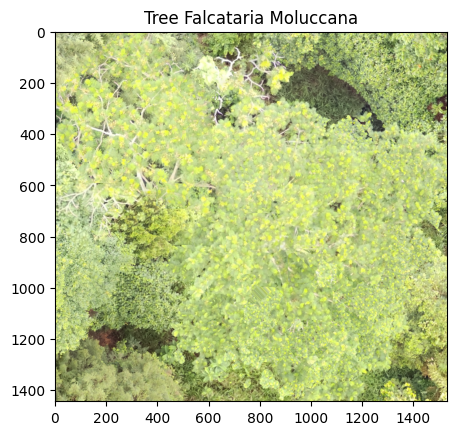

In [3]:
import matplotlib.pyplot as plt

def visualize(segment: np.ndarray, label: str):
    segment_0_rgb = segment[..., [2, 1, 0]]
    segment_0_rgb_scaled = scale_0_1_per_band(segment_0_rgb)

    plt.imshow(segment_0_rgb_scaled)
    plt.title(f"Tree {label}")
    plt.show()

visualize(segments[0], labels[0])

In [4]:
from typing import Dict, Tuple

def get_filtered_labels(labels: List[str]):
    # count number of examples for each label, filter only labels >= 2
    counter = {}
    for label in labels:
        counter[label] = counter.get(label, 0) + 1
    filtered_labels = {label for label, count in counter.items() if count > 1}
    return filtered_labels

def get_crowns(segments: List[np.ndarray], labels: List[str], filtered_labels: set[str]) -> Dict[str, np.ndarray]:
    crowns = {}
    for label, segment in zip(labels, segments):
        if label in filtered_labels:
            if label not in crowns:
                crowns[label] = []
            crowns[label].append(segment.transpose(2, 0, 1).reshape(8, -1))
    for label, _ in crowns.items():
        crowns[label] = np.hstack(crowns[label])
    return crowns

def get_random_pixels(crowns: Dict[str, List[np.ndarray]], 
                      pixel_count: int = 20000,
                      seed: int = 42) -> Dict[str, np.ndarray]:
    np.random.seed(seed)
    simulated_crowns = {}
    for label, segs in crowns.items():
        idxes = np.random.choice(segs.shape[-1], pixel_count)
        simulated_crowns[label] = segs[:, idxes]
    return simulated_crowns

def create_simulated_plots(simulated_crowns: Dict[str, np.ndarray],
                           species_per_eu: int = 1,
                           eu_size: Tuple[int, int] = (36, 36),
                           num_eu: int = 9,
                           seed: int = 21):
    np.random.seed(seed)
    width = int(num_eu ** 0.5)
    simulated_plot = np.empty((8, (eu_size[0] * width), (eu_size[1] * width)))
    for i, (species, points) in enumerate(simulated_crowns.items()):
        idxes = np.random.choice(points.shape[-1], eu_size[0] * eu_size[1])
        selected_points = points[:, idxes].reshape((8, eu_size[0], eu_size[1]))
        x, y = i % 3, i // 3
        simulated_plot[:, x*eu_size[0]:(x+1)*eu_size[0], y*eu_size[1]:(y+1)*eu_size[1]] = selected_points
    return simulated_plot
    

filtered_labels = get_filtered_labels(labels)
crowns = get_crowns(segments, labels, filtered_labels)
simulated_crowns = get_random_pixels(crowns)
simulated_plots = create_simulated_plots(simulated_crowns)

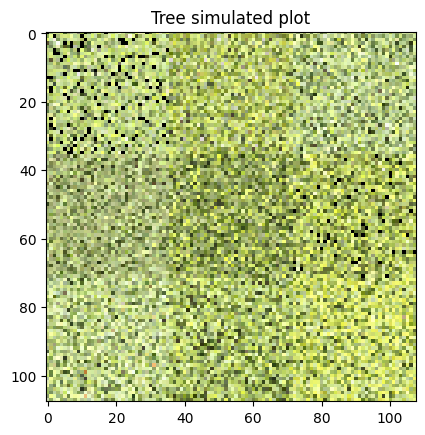

In [5]:
visualize(np.transpose(simulated_plots, (1, 2, 0)), "simulated plot")

(11664, 8)

In [10]:
from sklearn.decomposition import PCA

reshaped_plot = np.reshape(np.transpose(simulated_plots, (1, 2, 0)), (-1, 8))
pca = PCA(n_components=8)
pca.fit(reshaped_plot)
print(pca.explained_variance_ratio_)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
def shannon_index(arr: np.ndarray) -> np.ndarray:
    if arr.sum() != 1.0:
        arr = arr / arr.sum()
    score = -np.sum(arr * np.log(arr))
    return score

def bc_dissimilarity(abundances_matrices: np.ndarray) -> np.ndarray:
    """
    abundances_matrices will be a matrix of 2 dimensions
    m x n, where m is the number of species and n is the number of plots
    n(ik) represents the relative abundance of species k in plot i
    """
    pass
    